# A Data Love Story

This analysis examines the text message data between Partner A and Partner B throughout the course of their 
relationship. Will it end happily ever after?

In [0]:
import pandas as pd
import numpy as np
from altair import *
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import sent_tokenize, word_tokenize
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [0]:
df = pd.read_csv('/Users/vmartins/Downloads/sms_20170210.csv', encoding='latin-1')
df['Datetime'] = pd.to_datetime(df['Date'].map(str) + ' ' + df['Time']) #add a timestamp column
df['Msg_length'] = df['Message'].str.len() #add a message length column
chart = Chart(df) #make a chart object for altair

Let's look at the data. An 'in' message is a message incoming from Partner A to Partner B's smartphone and vice versa for an 'out' message. 

In [0]:
pd.DataFrame(df).head()

,Date,Time,Type,Message,Datetime,Msg_length
0,7/9/16,8:21:55,out,åÀCÌ_mo te fue anoche?,2016-07-09 08:21:55,22
1,7/9/16,8:54:49,in,"It was fun, we achieved our goal of annoying c...",2016-07-09 08:54:49,110
2,7/9/16,9:31:10,out,Ten long lonely minutes. By the time I found N...,2016-07-09 09:31:10,144
3,7/9/16,10:27:46,in,"Aw man, a whole 10?sounds scary but then again...",2016-07-09 10:27:46,80
4,7/9/16,11:09:21,out,"No no no, Natalyn ditched me on purpose",2016-07-09 11:09:21,40


The pair exchanges an average of 15.6 messages per day.

In [0]:
print( 'Avg daily messages: ' + str(df.groupby(['Date']).size().mean()))

Avg daily messages: 15.6038647343


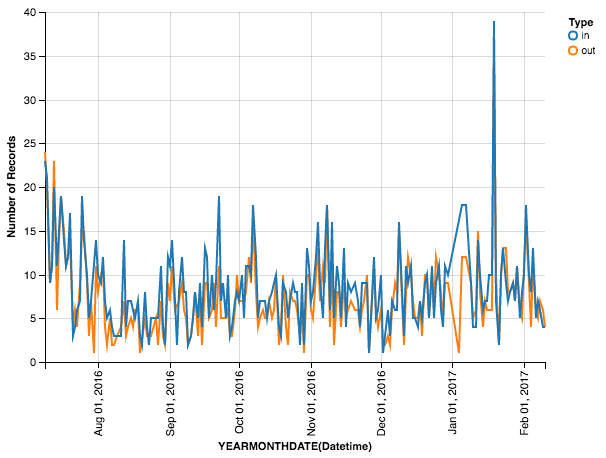

In [0]:
chart.mark_line().encode(
    x=X('Datetime:T', timeUnit='yearmonthdate'),
    y='count(*):Q',
     color='Type'
)

Partner A sends on average 1 more message per day than Partner B. Looks like someone likes to have the last word.

In [0]:
agg = df.groupby(['Date','Type']).size().unstack()
print ('Avg daily inbound messages: ' + str(agg['in'].mean())) 
print ('Avg daily outbound messages: ' + str(agg['out'].mean()))

Avg daily inbound messages: 8.40487804878
Avg daily outbound messages: 7.3512195122


Messaging peaks between 9 and 10 PM, falling off sharply thereafter. Smaller peaks occur at 9 AM, 1 PM, and 6 PM indicating the pair messages during breaks at work. Very little texting happens between midnight and 6 AM.

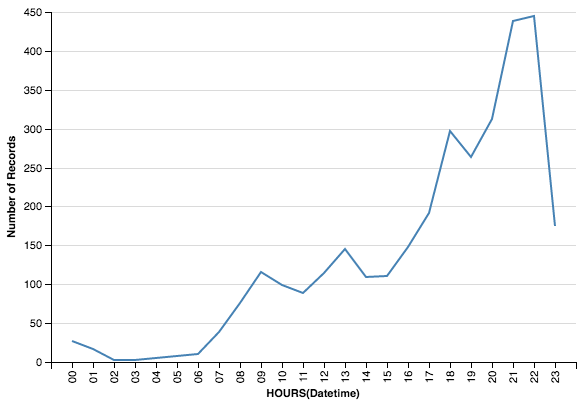

In [0]:
chart.mark_line().encode(
    X('Datetime:T', timeUnit='hours'),
    Y('count(*):Q')
)

Over time, Partner B has decreased monthly average message length by about 20 characters, while Partner A remains consistent over time.

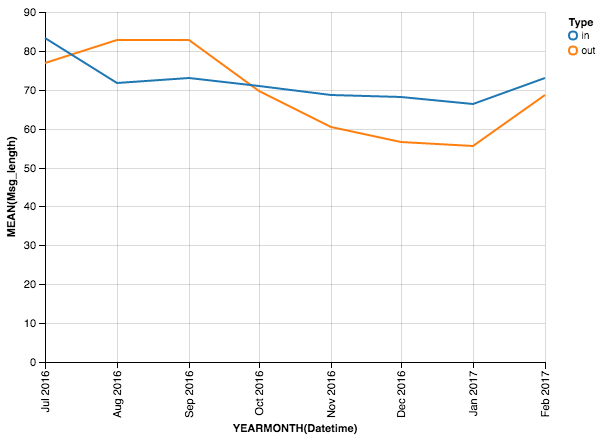

In [0]:
chart.mark_line().encode(
    x=X('Datetime:T', timeUnit='yearmonth'),
    y='mean(Msg_length)',
     color='Type'
)

In [0]:
#Add a pet name column
df.loc[df['Message'].str.contains('babe',case=False), 'Petnames'] = 'babe'
df.loc[df['Message'].str.contains('baby',case=False), 'Petnames'] = 'baby'
df.loc[df['Message'].str.contains('bae',case=False), 'Petnames'] = 'bae'
df.loc[df['Message'].str.contains('boo',case=False), 'Petnames'] = 'boo'

Both partners prefer 'boo' and 'baby' over 'babe' and 'bae.' Partner A uses 'boo' and 'babe' about twice as often as Partner B, whereas Partner B is only slightly more likely to use 'baby' and 'bae' than Partner A. Overall pet name usage is greater in incoming messages from Partner A.

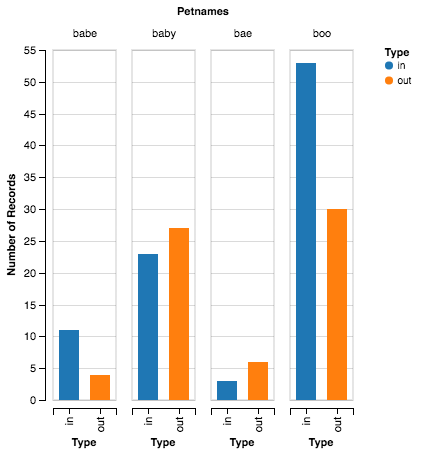

In [0]:
Chart(df.loc[df['Petnames'].notnull()]).mark_bar().encode(
    X('Type'),
    Y('count(*):Q'),
    color='Type',
    column='Petnames',  
)

'Boo' has been the top term throughout the relationship, only once being eclipsed by 'baby' in October 2016, but enjoying a marked increase in January. Will 2017 be the Year of the Boo?

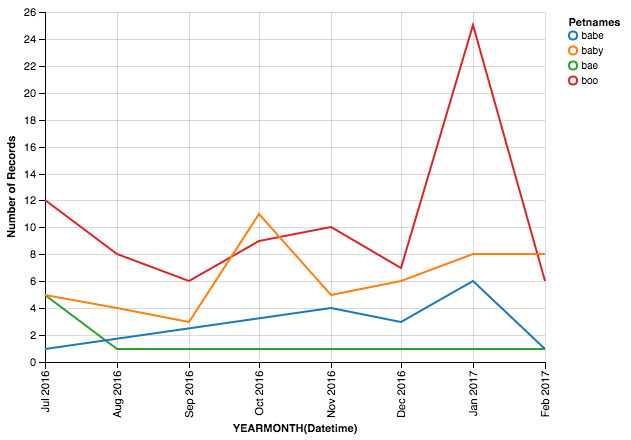

In [0]:
Chart(df.loc[df['Petnames'].notnull()]).mark_line().encode(
    X('Datetime:T', timeUnit='yearmonth'),
    Y('count(*):Q'),
    color='Petnames'
)

The median time between messages is 15 minutes.

In [0]:
df['Datediff'] = df['Datetime'].diff().fillna((0)) #add a column for time between messages
df['Datediff'].median()

Timedelta('0 days 00:15:05')

In [0]:
#build a corpus for LDA topic modeling
corpus = PlaintextCorpusReader('/Users/vmartins/Downloads/', 'messages_20170210.txt')
sample = corpus.raw("messages_20170210.txt")
tok = sent_tokenize(sample)

In [0]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(tok)
print(dtm_tf.shape)

(3673, 355)


In [0]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(tok)
print(dtm_tfidf.shape)

(3673, 355)


In [0]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_topics=10, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_topics=10, random_state=0)
lda_tfidf.fit(dtm_tfidf)

/Users/vmartins/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/vmartins/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=10, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

Explore the top ten topics below to get a closer look at the pair's favorite conversations:
1. Dream about pretty and perfect faces
2. The best day at the beach
3. Awkward creepy Penny
4. Little goat trips
5. Cute sleep on an Oakland vacation
6. Sooo wait...sorry boo
7. Stop, adorable tiny sloth baby
8. Tortellini eats Christmas cookies
9. Super big gay party
10. Excited about bed, beer, coffee and rainbows

In [0]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      13.851278        1       1  0.232912 -0.112452
2      12.264039        1       2  0.087893 -0.038125
9      11.019695        1       3  0.140726 -0.179415
1      10.507334        1       4 -0.014870 -0.023795
4      10.176498        1       5  0.060168  0.235758
8       9.477931        1       6 -0.282100 -0.109093
7       9.146638        1       7 -0.042050 -0.078476
5       8.879795        1       8 -0.037298  0.272323
3       7.548301        1       9  0.054132  0.090569
6       7.128490        1      10 -0.199513 -0.057294, topic_info=     Category        Freq     Term       Total  loglift  logprob
term                                                            
75    Default  127.000000      did  127.000000  30.0000  30.0000
173   Default  169.000000     like  169.000000  29.0000  29.0000
179   Default   97.000000      lol   97.000000  28.0000  28.0000
126   Default   80.000000      got   80.000000  27.0000  27.0000
122   Default   81.000000    going   81.000000  26.0000  26.0000
83    Default  108.000000      don  108.000000  25.0000  25.0000
323   Default   71.000000     want   71.000000  24.0000  24.0000
124   Default  107.000000     good  107.000000  23.0000  23.0000
164   Default   82.000000     know   82.000000  22.0000  22.0000
351   Default   68.000000      yes   68.000000  21.0000  21.0000
177   Default   83.000000   little   83.000000  20.0000  20.0000
300   Default   98.000000     time   98.000000  19.0000  19.0000
303   Default   62.000000    today   62.000000  18.0000  18.0000
296   Default   78.000000    think   78.000000  17.0000  17.0000
159   Default  175.000000     just  175.000000  16.0000  16.0000
343   Default   58.000000     work   58.000000  15.0000  15.0000
64    Default   56.000000     cute   56.000000  14.0000  14.0000
69    Default   61.000000      day   61.000000  13.0000  13.0000
123   Default   47.000000    gonna   47.000000  12.0000  12.0000
208   Default   51.000000     need   51.000000  11.0000  11.0000
249   Default   55.000000    right   55.000000  10.0000  10.0000
98    Default   58.000000     face   58.000000   9.0000   9.0000
186   Default   45.000000     love   45.000000   8.0000   8.0000
294   Default   49.000000    thing   49.000000   7.0000   7.0000
15    Default   43.000000     baby   43.000000   6.0000   6.0000
172   Default   45.000000     life   45.000000   5.0000   5.0000
194   Default   45.000000     mean   45.000000   4.0000   4.0000
22    Default   37.000000      bed   37.000000   3.0000   3.0000
26    Default   47.000000     best   47.000000   2.0000   2.0000
267   Default   42.000000    sleep   42.000000   1.0000   1.0000
...       ...         ...      ...         ...      ...      ...
201   Topic10   24.579637      mom   26.154938   2.5790  -3.2397
216   Topic10   20.576724   office   22.151983   2.5673  -3.4175
99    Topic10   20.469011   family   22.045904   2.5669  -3.4228
253   Topic10   19.973563      sad   21.548645   2.5652  -3.4473
354   Topic10   19.435374      yup   21.010406   2.5631  -3.4746
63    Topic10   18.782287   cuddle   20.357352   2.5605  -3.5087
52    Topic10   17.222718   coffee   18.797797   2.5536  -3.5954
353   Topic10   16.984107   yessss   18.559150   2.5524  -3.6094
18    Topic10   15.320581     bart   16.895726   2.5432  -3.7125
213   Topic10   13.155484     nooo   14.730532   2.5280  -3.8648
161   Topic10   12.787239     kind   14.362280   2.5249  -3.8932
33    Topic10   12.646293     book   14.221491   2.5237  -3.9043
207   Topic10   11.617417     neck   13.192495   2.5139  -3.9892
87    Topic10   10.630623    drive   12.205667   2.5029  -4.0779
243   Topic10   12.247561  rainbow   17.327354   2.2941  -3.9363
80    Topic10   13.465379    doesn   20.124628   2.2392  -3.8415
189   Topic10    7.866038     make   60.847865   0.5952  -4.3791
173   Topic10   19.747949     like  169.579252   0.4908  -3

To see the interactive topic visualization, go to [nbviewer](http://nbviewer.jupyter.org/github/vmartins321/LDA-topic-modeling/blob/4cae2fccd7b03786932ef3881c8a8970fc159413/LDA-topic-modeling.ipynb)